<a href="https://colab.research.google.com/github/shlomi1993/deep-learning-notebooks/blob/main/8_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8 - Auto-Encoder

## Introduction

In this notebook, we construct a **deep autoencoder** whose decoder mirrors the encoder with an equal number of layers, encouraging each decoder layer to approximate the inverse function of its corresponding encoder layer.

We implement this architecture using fully connected layers, select an appropriate loss function to measure the closeness between encoder and decoder layers, and train the model on the MNIST dataset.

We then analyze the layer-wise inversion accuracy, experiment with different network architectures, and compare the performance of fully connected versus convolutional autoencoders, discussing the architectural trade-offs and preferences.

### Global Code

#### Import Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle

from random import random
from typing import List, Tuple, Dict, Any
from collections import Counter
from copy import deepcopy
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

#### Reference Accelerator Device

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

#### Implement Performance History Class

To track and visualize a model performance over time in both questions, we introduce the `PerformanceHistory` class that provides a structured way to store and plot loss and accuracy metrics across training or evaluation epochs.

In [ ]:
class PerformanceHistory:
    """
    Record loss and accuracy metrics over time and provides plotting functionality.
    """
    def __init__(self) -> None:
        """
        Initializes the history with empty lists for loss and accuracy.
        """
        self.loss = []
        self.accuracy = []

    def add(self, loss: float, accuracy: float) -> None:
        """
        Adds new metrics to the history.

        Args:
            loss (float): Average loss for the epoch.
            accuracy (float): Pixel-wise accuracy for the epoch.
        """
        self.loss.append(loss)
        self.accuracy.append(accuracy)

    def plot(self, title: str = "Loss and Accuracy over Epochs") -> None:
        """
        Plots loss and accuracy side by side.
        """
        # Create a sequence of epoch numbers for the x-axis
        epochs = range(1, len(self.loss) + 1)

        # Set the overall figure size and title
        plt.figure(figsize=(12, 4))
        plt.suptitle(title, fontsize=14)

        # Plot loss on the left subplot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.loss, marker='o')  # Plot loss values with markers
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        # Plot accuracy on the right subplot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, [a * 100 for a in self.accuracy], marker='o', color='green')  # Convert accuracy to % and plot
        plt.title('Pixel-wise Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')

        # Adjust spacing between subplots and suptitle
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        # Display the plots
        plt.show()

## Train a Deep Autoencoder on MNIST

autoencoder where the encoder and decoder have the same number of layers, and each decoder layer closely approximates the inverse of its corresponding encoder layer. While perfect inversion may not be possible, especially if some functions used in the network are not inherently invertible, the network should be incentivized to follow this structure as closely as possible.

### Load MNIST dataset

In [ ]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

### Build Autoencoder

We'll define a deep autoencoder, train it on MNIST, and save the encoder outputs for later analysis.

#### Implement Encoder

In [ ]:
class Encoder(nn.Module):
    """
    Encoder module for the deep autoencoder.

    This network reduces the input MNIST image (28x28) down to a lower dimensional latent vector.
    It uses fully connected (linear) layers and ReLU activations.
    """
    def __init__(self, latent_dim: int) -> None:
        """
        Initializes the encoder architecture.

        Args:
            latent_dim (int): Dimension of the latent (bottleneck) representation.
        """
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),               # Flatten the 2D image to a 1D vector
            nn.Linear(28 * 28, 256),    # First FC layer
            nn.ReLU(),                  # Activation
            nn.Linear(256, 64),         # Second FC layer
            nn.ReLU(),                  # Activation
            nn.Linear(64, latent_dim)   # Output layer to latent space
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass through the encoder.

        Args:
            x (Tensor): Input image tensor of shape (batch_size, 1, 28, 28)

        Returns:
            Tensor: Latent representation of shape (batch_size, latent_dim)
        """
        return self.encoder(x)

#### Implement Decoder

In [ ]:
class Decoder(nn.Module):
    """
    Decoder module for the deep autoencoder.

    This network attempts to reconstruct the original image from the latent vector.
    It mirrors the architecture of the encoder as closely as possible.
    """
    def __init__(self, latent_dim) -> None:
        """
        Initializes the decoder architecture.

        Args:
            latent_dim (int): Dimension of the latent (bottleneck) representation.
        """
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),  # First FC layer
            nn.ReLU(),                  # Activation
            nn.Linear(64, 256),         # Second FC layer
            nn.ReLU(),                  # Activation
            nn.Linear(256, 28 * 28),    # Output layer
            nn.Sigmoid()                # Sigmoid to map pixel values between 0 and 1
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass through the decoder.

        Args:
            x (Tensor): Latent vector.

        Returns:
            Tensor: Reconstructed image tensor.
        """
        x = self.decoder(x)
        return x.view(-1, 1, 28, 28)  # Reshape to image format

#### Assemble Autoencoder from Encoder and Decoder

In [ ]:
class Autoencoder(nn.Module):
    """
    Autoencoder model that combines the encoder and decoder.

    The model takes an image as input, encodes it to a latent vector, then decodes it back to the reconstructed image.
    """
    def __init__(self, latent_dim: int = 16) -> None:
        """
        Initializes the autoencoder with an encoder and decoder.

        Args:
            latent_dim (int): Dimension of the latent (bottleneck) representation.
        """
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass through the autoencoder.

        Args:
            x (Tensor): Input image tensor.

        Returns:
            Tensor: Reconstructed image tensor of the same shape.
        """
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, train_loader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, n_epochs: int = 10) -> PerformanceHistory:
        """
        Trains the autoencoder on the given training data using the provided optimizer and loss criterion.

        The method trains the model for the specified number of epochs and prints the average reconstruction loss and
        pixel-wise accuracy for each epoch (percentage of pixels where reconstructed output matches input after
        binarization at 0.5 threshold).

        Args:
            train_loader (DataLoader): DataLoader providing the training data batches.
            optimizer (torch.optim.Optimizer): Optimizer used to update model parameters.
            criterion (nn.Module): Loss function used to compute reconstruction loss.
            n_epochs (int): Number of training epochs. Default is 10.

        Returns:
            PerformanceHistory: Object containing lists of per-epoch loss and accuracy, and a plot method.
        """
        self.to(DEVICE)

        history = PerformanceHistory()

        for epoch in tqdm(range(1, n_epochs + 1), desc="Training", unit="epoch"):
            self.train()
            total_loss = 0
            total_pixels = 0
            correct_pixels = 0

            # Iterate over training batches with inner progress bar
            batches = tqdm(train_loader, desc=f"Epoch {epoch} Batches", leave=False)
            for x, _ in batches:
                x = x.to(DEVICE)
                optimizer.zero_grad()       # Reset gradients
                output = self(x)            # Forward pass
                loss = criterion(output, x) # Compute MSE loss
                loss.backward()             # Backpropagation
                optimizer.step()            # Update model weights
                total_loss += loss.item()   # Accumulate loss

                # Calculate pixel-wise accuracy after binarization at 0.5
                correct_pixels += ((output - x).abs() < 0.1).sum().item()
                total_pixels += x.numel()

            avg_loss = total_loss / len(train_loader)
            accuracy = correct_pixels / total_pixels

            # Record epoch metrics using PerformanceHistory object
            history.add(loss=avg_loss, accuracy=accuracy)

            print(f"Epoch {epoch}/{n_epochs}, Loss: {avg_loss:.4f}, Pixel-wise Accuracy: {accuracy * 100:.2f}%")

        return history

So far, we built a deep autoencoder consisting of an encoder and a decoder, both using fully connected layers. The encoder compresses $28 \times 28$ images into a low dimensional latent vector, while the decoder reconstructs the original image from this compressed form. The decoder mirrors the encoder's structure to approximate its inverse, encouraging the network to learn meaningful, structured representations. We also added a `fit` method to the autoencoder class, which handles the training process over multiple epochs using reconstruction loss.

Now we train the autoencoder on MNIST dataset...

### Train Autoencoder

#### Instantiate Autoencoder and Define Optimizer and Loss

In [ ]:
autoencoder = Autoencoder(latent_dim=16)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Reconstruction loss

- A latent dimension of 16 seems to balance compression and information retention for effective image reconstruction.

- The learning rate of 0.001 for the Adam optimizer is a common default that provides stable and efficient training.

- The mean squared error (MSE) loss is used as the reconstruction loss since it effectively measures the pixel-wise difference between the input and the reconstructed output, encouraging accurate image reconstruction.

#### Train

In [ ]:
history = autoencoder.fit(train_loader, optimizer, criterion, n_epochs=10)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.0551, Pixel-wise Accuracy: 68.50%


Epoch 2 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.0276, Pixel-wise Accuracy: 79.77%


Epoch 3 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.0226, Pixel-wise Accuracy: 82.48%


Epoch 4 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.0199, Pixel-wise Accuracy: 83.88%


Epoch 5 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.0175, Pixel-wise Accuracy: 85.15%


Epoch 6 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.0160, Pixel-wise Accuracy: 85.98%


Epoch 7 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.0150, Pixel-wise Accuracy: 86.58%


Epoch 8 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.0142, Pixel-wise Accuracy: 86.99%


Epoch 9 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.0137, Pixel-wise Accuracy: 87.30%


Epoch 10 Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.0131, Pixel-wise Accuracy: 87.60%


We now have a trained autoencoder that compresses MNIST digits into a 16-dimensional latent space.

Next, we analyze the model's output representations.

#### Plot Performance

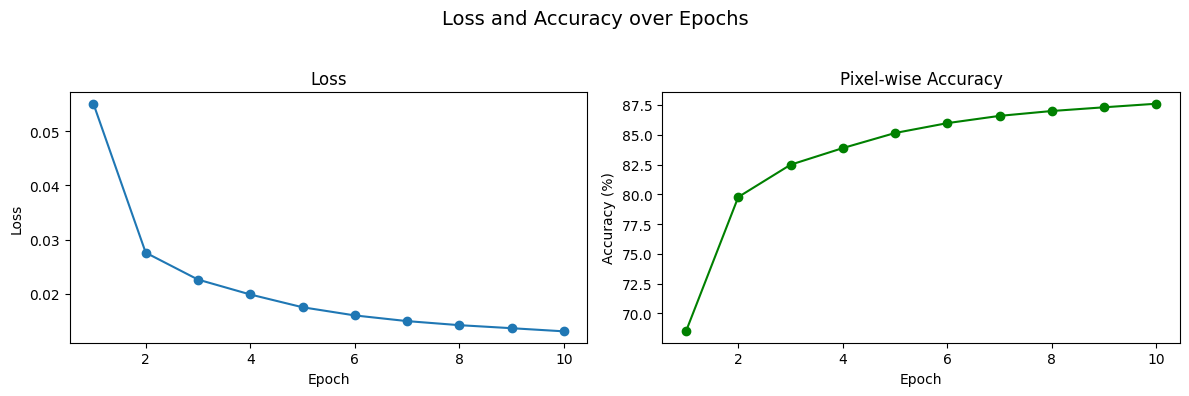

In [ ]:
history.plot()

- The plot shows the training performance of the autoencoder over 10 epochs.

- On the left, the loss curve steadily decreases, with a rapid initial drop followed by slower improvement, indicating effective learning.

- On the right, pixel-wise accuracy rises from around 68% to nearly 87%, confirming that reconstructions closely match the input images and that the model is converging well.

### How close is each decoder layer to the inverse of its encoder counterpart?

We now analyze how well the decoder of an autoencoder approximates the inverse of its encoder. Specifically, we compare each encoder layer's weight matrix to the transpose of the corresponding decoder layer's weight matrix using cosine similarity — a metric that measures alignment between vectors, or in this case, flattened matrices.

In an ideal autoencoder, the decoder would effectively "undo" the transformations of the encoder. If true invertibility holds, the decoder's transposed weights should closely align with the encoder's weights.

In [ ]:
# Extract weights from encoder layers excluding activations
encoder_weights = [
    autoencoder.encoder.encoder[1].weight.data,  # Linear(784 to 256)
    autoencoder.encoder.encoder[3].weight.data,  # Linear(256 to 64)
    autoencoder.encoder.encoder[5].weight.data   # Linear(64 to latent_dim)
]

# Extract weights from decoder layers excluding activations
decoder_weights = [
    autoencoder.decoder.decoder[0].weight.data,  # Linear(latent_dim to 64)
    autoencoder.decoder.decoder[2].weight.data,  # Linear(64 to 256)
    autoencoder.decoder.decoder[4].weight.data   # Linear(256 to 784)
]

print("Cosine similarity between encoder weight and transpose of corresponding decoder weight:\n")

# Compare each reversed encoder layer to the matching decoder layer
for i, (enc_w, dec_w) in enumerate(zip(reversed(encoder_weights), decoder_weights)):
    # Flatten the transpose if enc_w and compute cosine similarity
    similarity = F.cosine_similarity(enc_w.T.flatten(), dec_w.flatten(), dim=0)
    print(f"Layer {i+1}: Cosine similarity = {similarity.item():.4f}")

Cosine similarity between encoder weight and transpose of corresponding decoder weight:

Layer 1: Cosine similarity = -0.0048
Layer 2: Cosine similarity = -0.0116
Layer 3: Cosine similarity = 0.0163


The results show that the cosine similarities are close to zero, indicating that the decoder layers are not approximating the mathematical inverse of the encoder layers. In other words, the network is not learning symmetric transformations. The decoder is not simply reversing the encoder via transposed weights.

### Define Autoencoder with Configurable Layers

In [ ]:
class ConfigurableAutoencoder(nn.Module):
    """
    Fully connected autoencoder with configurable layers that compresses input images into a latent representation and
    reconstructs them back to their original form. The encoder architecture is defined by a list of hidden layer sizes.
    The decoder mirrors the encoder's structure to reconstruct the input image.
    """
    def __init__(self, latent_dim: int, encoder_sizes: List[int]) -> None:
        """
        Initializes the encoder and decoder networks.

        Args:
            latent_dim (int): Dimension of the latent (bottleneck) representation.
            encoder_sizes (List[int]): List of hidden layer sizes in the encoder.
        """
        super().__init__()

        # Build encoder
        encoder_layers = []
        in_dim = 28 * 28  # Flattened MNIST image size
        for h in encoder_sizes:
            encoder_layers.append(nn.Linear(in_dim, h))
            encoder_layers.append(nn.ReLU())
            in_dim = h
        encoder_layers.append(nn.Linear(in_dim, latent_dim))  # Final bottleneck layer
        self.encoder = nn.Sequential(*encoder_layers)

        # Build decoder that mirror the encoder
        decoder_layers = []
        in_dim = latent_dim
        for h in reversed(encoder_sizes):
            decoder_layers.append(nn.Linear(in_dim, h))
            decoder_layers.append(nn.ReLU())
            in_dim = h
        decoder_layers.append(nn.Linear(in_dim, 28 * 28))  # Output layer
        decoder_layers.append(nn.Sigmoid())                # Output pixel values in [0, 1]
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the autoencoder. The input image is flattened, encoded into a latent representation, and
        then decoded back to the original image shape.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Reconstructed image tensor.
        """
        x = x.view(x.size(0), -1)  # Flatten the image
        z = self.encoder(x)        # Encode to latent space
        return self.decoder(z)     # Decode back to image

    def fit(self, train_loader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, n_epochs: int = 10) -> PerformanceHistory:
        """
        Trains the autoencoder using the provided training data, optimizer, and loss function. After each epoch, prints
        the average reconstruction loss and pixel-wise accuracy (based on a 0.5 threshold). Accuracy is calculated as
        the ratio of correctly reconstructed pixels to total pixels.

        Args:
            train_loader (DataLoader): DataLoader for training images.
            optimizer (torch.optim.Optimizer): Optimizer for model parameters.
            criterion (nn.Module): Loss function, e.g., nn.MSELoss().
            n_epochs (int): Number of training epochs.

        Returns:
            PerformanceHistory: Object that stores per-epoch loss and accuracy metrics.
        """
        # Use GPU if available
        self.to(DEVICE)

        # For loss and accuracy record
        history = PerformanceHistory()

        # Training loop
        for epoch in tqdm(range(1, n_epochs + 1), desc="Training", unit="epoch"):
            self.train()
            total_loss = 0.0
            total_pixels = 0
            correct_pixels = 0

            # Iterate over batches
            for x, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
                x = x.to(DEVICE)

                # Forward-backward pass
                optimizer.zero_grad()
                output = self(x)
                loss = criterion(output, x.view(x.size(0), -1))
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * x.size(0)  # Accumulate weighted loss

                # Calculate pixel-wise accuracy
                correct_pixels += ((output - x.view(x.size(0), -1)).abs() < 0.1).sum().item()
                total_pixels += x.numel()

            # Calculate epoch's average loss and accuracy
            avg_loss = total_loss / len(train_loader.dataset)
            accuracy = correct_pixels / total_pixels

            # Store metrics
            history.add(loss=avg_loss, accuracy=accuracy)

            print(f"Epoch {epoch}/{n_epochs}, Loss: {avg_loss:.4f}, Pixel-wise Accuracy: {accuracy * 100:.2f}%")

        return history

The `ConfigurableAutoencoder` class defines a fully connected autoencoder architecture that allows flexible control over the encoder's depth and hidden layer sizes. It is designed to compress $28 \times 28$ grayscale images (such as MNIST digits) into a low-dimensional latent representation and reconstruct them back to their original form.

The encoder is constructed using a sequence of linear layers with ReLU activations, where the structure is defined by a user-provided list `encoder_sizes`. The final encoder layer maps the last hidden representation to a latent vector of size `latent_dim`. The decoder mirrors this architecture by reversing the encoder's layer sizes and concludes with a sigmoid activated output layer that produces pixel values in the range $[0, 1]$.

The `forward` method flattens the input images, passes them through the encoder to obtain the latent representation, and then decodes the result back to image space.

The `fit` method trains the model over a specified number of epochs using a provided optimizer and loss criterion. It also calculates and logs both the average reconstruction loss and pixel-wise accuracy (based on a binarization threshold of 0.5) for each epoch. All performance metrics are recorded using a PerformanceHistory object, which supports tracking and visualization of training progress.

### Test Different Autoencoder Architectures

#### Define Different Architectures

We define each architecture by a list of hidden layer sizes for the encoder. The decoder will mirror the encoder structure in reverse.

In [ ]:
architectures = {
    "Baseline": [256, 64],          # Moderate depth - the one we executed with the non-customizable Autoencoder
    "Small":    [16],               # Very limited capacity
    "Shallow":  [128],              # Single flat hidden layer
    "Deep":     [512, 256, 128],    # Deeper network with more capacity
    "Sharp":    [8, 7, 6, 5, 4]     # Many small layers
}

#### Train Each Model Architecture

For each architecture, create a model, train it, and store history

In [ ]:
latent_dim = 16
n_epochs = 5  # Sufficient for comparing relative performance across multiple models
learning_rate = 0.001
criterion = nn.MSELoss()

histories = dict()  # Map architecture name (str) to model performance (PerformanceHistory)
for arch_name, encoder_sizes in tqdm(architectures.items(), desc="Training Architectures"):
    config_autoencoder = ConfigurableAutoencoder(latent_dim, encoder_sizes)
    optimizer = optim.Adam(config_autoencoder.parameters(), lr=learning_rate)
    print(f"\nTraining {arch_name} model using Adam optimizer with learning rate of {learning_rate}...")
    histories[arch_name] = config_autoencoder.fit(train_loader, optimizer, criterion, n_epochs)

Training Architectures:   0%|          | 0/5 [00:00<?, ?it/s]


Training Baseline model using Adam optimizer with learning rate of 0.001...


Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0523, Pixel-wise Accuracy: 70.13%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0264, Pixel-wise Accuracy: 80.29%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0212, Pixel-wise Accuracy: 83.12%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0186, Pixel-wise Accuracy: 84.57%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0169, Pixel-wise Accuracy: 85.54%

Training Small model using Adam optimizer with learning rate of 0.001...


Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0770, Pixel-wise Accuracy: 58.03%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0470, Pixel-wise Accuracy: 70.55%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0414, Pixel-wise Accuracy: 73.43%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0381, Pixel-wise Accuracy: 75.05%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0361, Pixel-wise Accuracy: 76.11%

Training Shallow model using Adam optimizer with learning rate of 0.001...


Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0494, Pixel-wise Accuracy: 70.28%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0235, Pixel-wise Accuracy: 81.24%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0189, Pixel-wise Accuracy: 84.17%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0172, Pixel-wise Accuracy: 85.28%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0163, Pixel-wise Accuracy: 85.84%

Training Deep model using Adam optimizer with learning rate of 0.001...


Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0536, Pixel-wise Accuracy: 69.77%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0272, Pixel-wise Accuracy: 80.33%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0211, Pixel-wise Accuracy: 83.38%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0178, Pixel-wise Accuracy: 85.12%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0158, Pixel-wise Accuracy: 86.19%

Training Sharp model using Adam optimizer with learning rate of 0.001...


Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.1068, Pixel-wise Accuracy: 43.18%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0674, Pixel-wise Accuracy: 62.38%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0673, Pixel-wise Accuracy: 62.33%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0673, Pixel-wise Accuracy: 62.32%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0673, Pixel-wise Accuracy: 62.32%


Now let's plot the performance metrics for each architecture

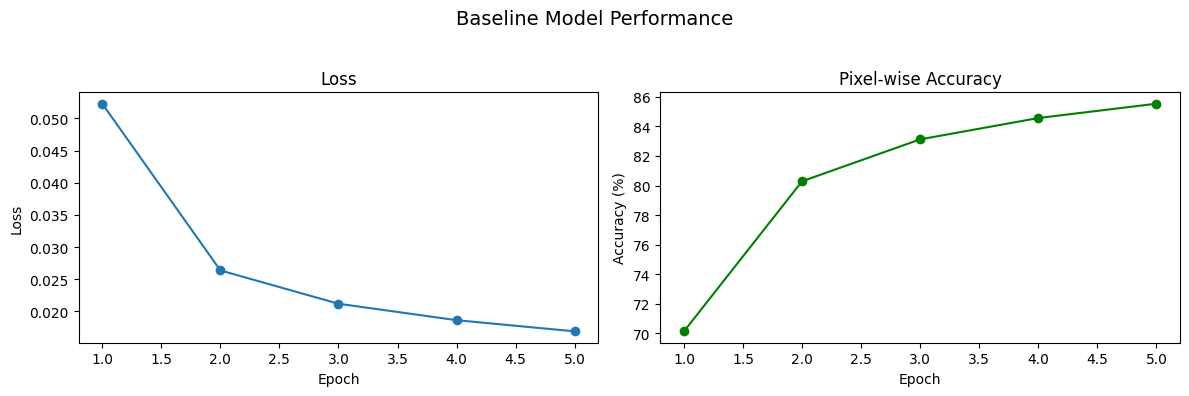

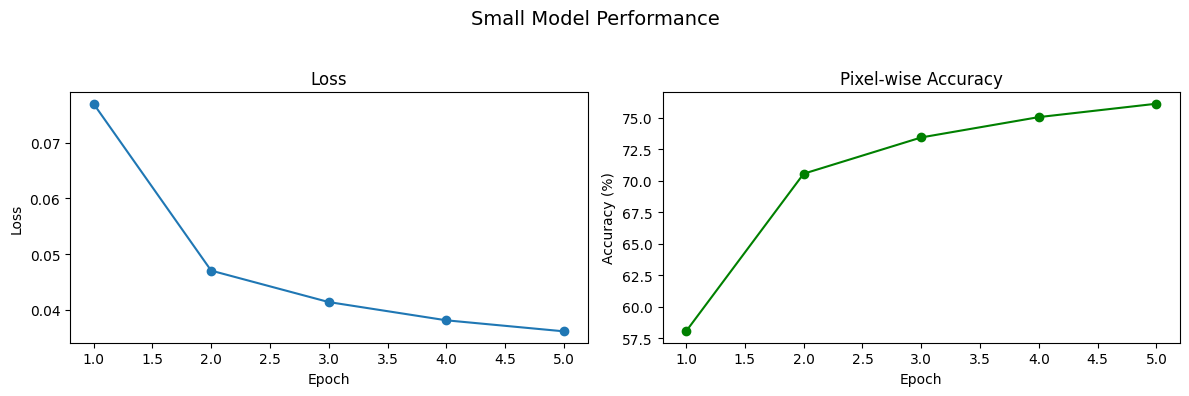

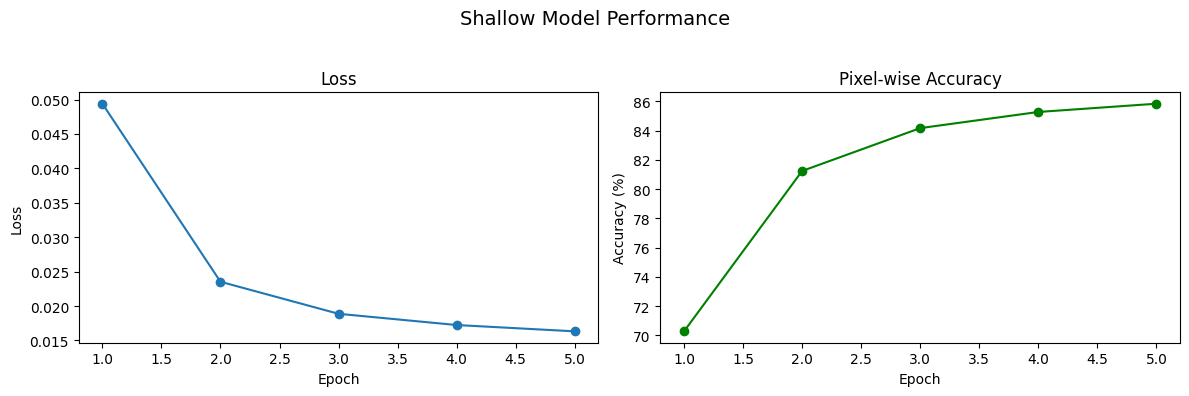

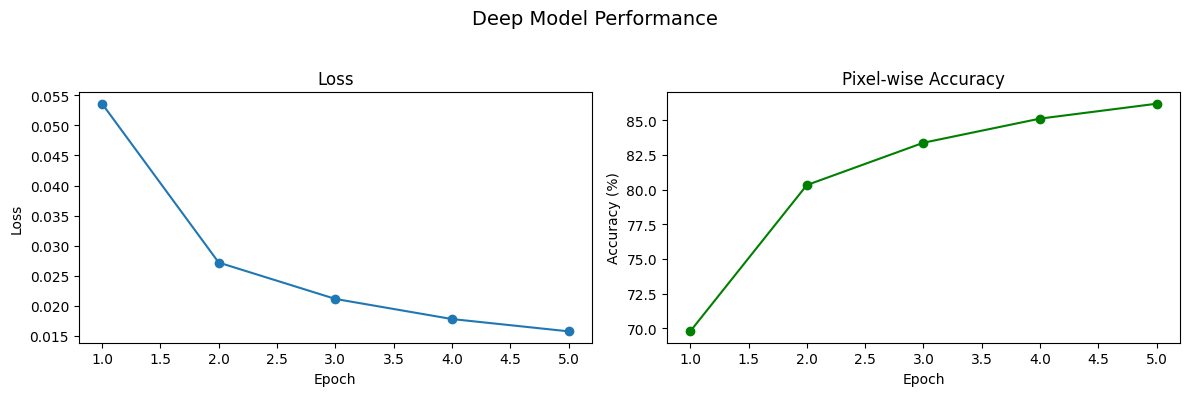

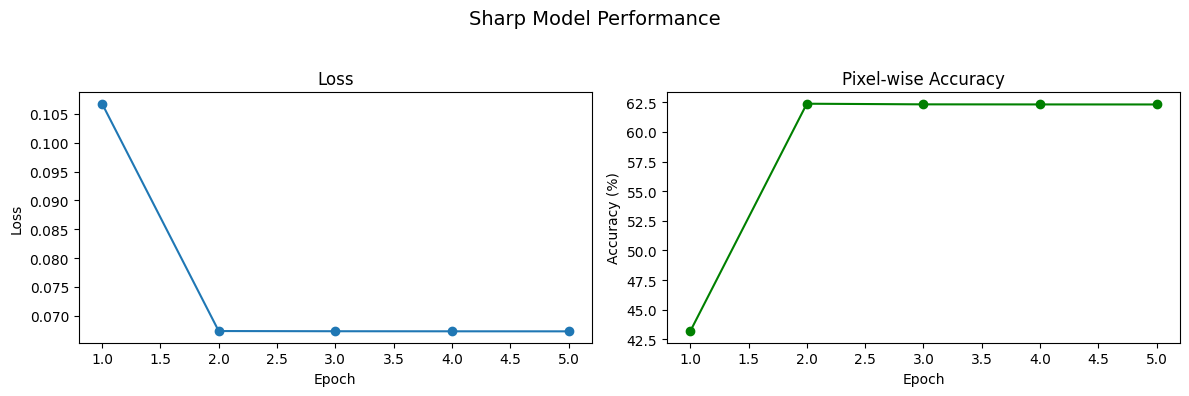

In [ ]:
for arch_name, history in histories.items():
    history.plot(title=f"{arch_name} Model Performance")

**Model Analyses (based on 5 epochs):**

- **Baseline Model:** Shows steady loss reduction and reaches ~85.5% accuracy. It performs well overall, serving as a balanced reference architecture.

- **Shallow Model:** Performs similarly to the baseline, with slightly better accuracy (~86%) and rapid convergence. Demonstrates that a simple, wide network can be very effective.

- **Small Model:** Starts with higher loss and ends with lower accuracy (~75.5%), reflecting limited capacity and slower learning due to fewer hidden units.

- **Deep Model:** Learns more gradually but reaches high accuracy (~85.5%) and low loss, benefiting from its increased depth and capacity.

- **Sharp Model:** Starts with a very high loss and quickly plateaus at ~62% accuracy, indicating underfitting likely due to an overly narrow bottleneck or unbalanced layer dimensions.

All models except Small and Sharp achieve high accuracy (~85.5-86%) within 5 epochs. The Shallow and Deep models perform best, while the Sharp model significantly underperforms due to architectural limitations.

### Identify Best and Worst Architectures

We use the final training loss stored in `history.loss` of each `history` object in `histories` dict, to find the architecture with the lowest loss and call it “best”, and the architecture with the highest loss and call it “worst”

In [ ]:
key = lambda x: x[1].loss[-1]

sorted_histories = dict(sorted(histories.items(), key=key))

for i, (arch_name, history) in enumerate(sorted_histories.items(), start=1):
    print(f"{i}. {arch_name:<8} : final loss = {history.loss[-1]:.4f}")

1. Deep     : final loss = 0.0158
2. Shallow  : final loss = 0.0163
3. Baseline : final loss = 0.0169
4. Small    : final loss = 0.0361
5. Sharp    : final loss = 0.0673


In [ ]:
best_ae_model_name = min(histories.items(), key=key)[0]
worst_ae_model_name = max(histories.items(), key=key)[0]

print(f"Best AE model:  {best_ae_model_name}")
print(f"Worst AE model: {worst_ae_model_name}")

Best AE model:  Deep
Worst AE model: Sharp


The Deep model performed best, slightly ahead of the Shallow and Baseline models. Small and Sharp models showed much higher loss, indicating underfitting. Simpler architectures can still achieve strong results.

### Fully Retrain Best and Worst Models

We retrain the best and worst models from scratch (same data, same settings) so we can later visualise their reconstructions and have fresh `history` objects that include both loss and accuracy.

In [ ]:
best_ae_model = ConfigurableAutoencoder(latent_dim, architectures[best_ae_model_name]).to(DEVICE)
worst_ae_model = ConfigurableAutoencoder(latent_dim, architectures[worst_ae_model_name]).to(DEVICE)

print(f"Training the bst AE model ({best_ae_model_name})...")
best_history = best_ae_model.fit(train_loader, optim.Adam(best_ae_model.parameters()), nn.MSELoss(), n_epochs=10)

print("\n")

print(f"Training the worst AE model ({worst_ae_model_name})...")
worst_history = worst_ae_model.fit(train_loader, optim.Adam(worst_ae_model.parameters()), nn.MSELoss(), n_epochs=10)

Training the bst AE model (Deep)...


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.0545, Pixel-wise Accuracy: 69.32%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.0277, Pixel-wise Accuracy: 80.05%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.0214, Pixel-wise Accuracy: 83.21%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.0186, Pixel-wise Accuracy: 84.72%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.0171, Pixel-wise Accuracy: 85.49%


Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.0157, Pixel-wise Accuracy: 86.23%


Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.0144, Pixel-wise Accuracy: 86.88%


Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.0133, Pixel-wise Accuracy: 87.52%


Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.0124, Pixel-wise Accuracy: 87.98%


Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.0117, Pixel-wise Accuracy: 88.36%


Training the worst AE model (Sharp)...


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.1032, Pixel-wise Accuracy: 47.33%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.0638, Pixel-wise Accuracy: 65.21%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.0622, Pixel-wise Accuracy: 66.24%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.0613, Pixel-wise Accuracy: 66.61%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.0609, Pixel-wise Accuracy: 66.82%


Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.0607, Pixel-wise Accuracy: 66.81%


Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.0605, Pixel-wise Accuracy: 66.81%


Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.0604, Pixel-wise Accuracy: 66.84%


Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.0603, Pixel-wise Accuracy: 66.82%


Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.0602, Pixel-wise Accuracy: 66.81%


Now `best_history` and `worst_history` hold loss and accuracy per epoch.

### Visualise Reconstructions

Now, we displays `n_images` pairs of (original, reconstructed) images for a given trained autoencoder.

#### Implement `visualize_reconstructions` helper function

In [ ]:
def visualize_reconstructions(model: nn.Module, data_loader: DataLoader, n_images: int = 5) -> None:
    """
    Show side-by-side originals and reconstructions.

    Args:
        model (nn.Module): Trained autoencoder model.
        data_loader (DataLoader): DataLoader for the dataset.
        n_images (int): Number of images to display. Default is 5.
    """
    model.eval()
    images, _ = next(iter(data_loader))
    images = images[:n_images].to(DEVICE)

    with torch.no_grad():
        recons = model(images).cpu()

        # Reshape reconstructions to [batch_size, height, width]
        if recons.dim() == 2:  # Flat vectors, e.g. [batch_size, 784], reshape to 28x28 images
            edge = int(recons.shape[1] ** 0.5)
            recons = recons.view(-1, edge, edge)
        elif recons.dim() == 4 and recons.shape[1] == 1:  # Single channel image tensors, e.g. [batch_size, 1, 28, 28]
            recons = recons.squeeze(1)  # Remove the channel dimension
            edge = recons.shape[1]
        else:  # In other cases, assume images are already in shape [batch_size, height, width]
            edge = recons.shape[1]

    images = images.cpu()
    if images.dim() == 4 and images.shape[1] == 1:
        images = images.squeeze(1)  # Remove channel dim from original images if present

    # Plot original images and their reconstructions
    fig, axes = plt.subplots(2, n_images, figsize=(n_images * 2, 4))
    for i in range(n_images):
        axes[0, i].imshow(images[i], cmap="gray")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(recons[i], cmap="gray")
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


#### Visual comparison for best and worst models

Reconstructions produced by BEST model (Deep)


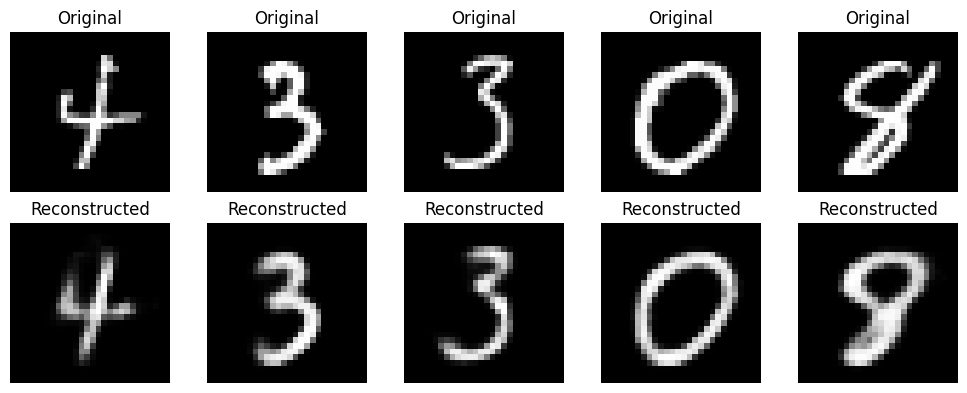



Reconstructions produced by WORST model (Sharp)


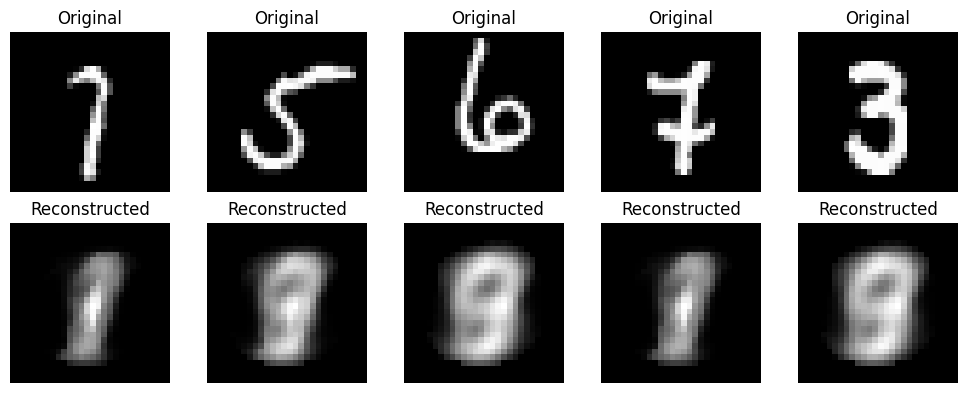

In [ ]:
print(f"Reconstructions produced by BEST model ({best_ae_model_name})")
visualize_reconstructions(best_ae_model, train_loader)

print("\n")

print(f"Reconstructions produced by WORST model ({worst_ae_model_name})")
visualize_reconstructions(worst_ae_model, train_loader)

The displayed grids clearly show the visual difference between high and low performing architectures, complementing the loss and accuracy metrics. The best model reconstructs the images quite well, though not perfectly, while the worst model produces noticeably poor results.

### Repeat the Process with Convolutional Networks

#### Define Convolutional Autoencoder

In [ ]:
class ConfigurableConvAutoencoder(nn.Module):
    """
    Configurable convolutional autoencoder for grayscale 28x28 images. One can specify the encoder channel sizes as a
    list, and the decoder will mirror the encoder architecture with transposed convolutions.
    """
    def __init__(self, encoder_channels: list[int]) -> None:
        """
        Args:
            encoder_channels (list of int): List of output channels for successive Conv2d layers in the encoder.
                Example: [16, 4] creates two conv layers: 1->16, then 16->4.
        """
        super().__init__()

        # Build encoder from channel list
        enc_layers = []
        in_channels = 1  # grayscale input
        for out_channels in encoder_channels:
            enc_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1))
            enc_layers.append(nn.ReLU())
            in_channels = out_channels
        self.encoder = nn.Sequential(*enc_layers)

        # Build decoder as reverse of encoder channels
        dec_layers = []
        reversed_channels = list(reversed(encoder_channels))
        for i in range(len(reversed_channels) - 1):
            convt2d = nn.ConvTranspose2d(
                in_channels=reversed_channels[i],
                out_channels=reversed_channels[i + 1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            )
            dec_layers.append(convt2d)
            dec_layers.append(nn.ReLU())

        # Final layer: output single channel (grayscale) with Sigmoid
        final_conv = nn.ConvTranspose2d(
            in_channels=reversed_channels[-1],
            out_channels=1,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )
        dec_layers.append(final_conv)
        dec_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the encoder and decoder to reconstruct the input image.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Reconstructed image tensor of the same shape as the input.
        """
        z = self.encoder(x)
        return self.decoder(z)

    def fit(self, train_loader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, n_epochs: int = 10) -> PerformanceHistory:
        """
        Trains the convolutional autoencoder using a pixel-wise reconstruction loss.

        Args:
            train_loader (DataLoader): DataLoader providing batches of grayscale images.
            optimizer (torch.optim.Optimizer): Optimizer for model training (e.g., Adam).
            criterion (nn.Module): Loss function for reconstruction (e.g., MSELoss).
            n_epochs (int): Number of training epochs. Default is 10.

        Returns:
            PerformanceHistory: Object storing loss and accuracy for each epoch.
        """
        self.to(DEVICE)
        history = PerformanceHistory()

        for epoch in tqdm(range(1, n_epochs + 1), desc=f"Training {self.__class__.__name__}", unit="epoch"):
            self.train()
            total_loss = 0.0
            total_pixels = 0
            correct_pixels = 0

            for x, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
                x = x.to(DEVICE)
                optimizer.zero_grad()
                output = self(x)

                # Crop output spatial dimensions to match input if needed
                if output.shape[-2:] != x.shape[-2:]:
                    # Calculate difference in height and width
                    h_diff = output.size(-2) - x.size(-2)
                    w_diff = output.size(-1) - x.size(-1)

                    # Crop equally from both sides if possible
                    h_start = h_diff // 2
                    w_start = w_diff // 2

                    output = output[:, :, h_start:h_start + x.size(-2), w_start:w_start + x.size(-1)]

                loss = criterion(output, x)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * x.size(0)

                # Pixel-wise accuracy: count pixels where absolute difference < 0.1
                correct_pixels += ((output - x).abs() < 0.1).sum().item()
                total_pixels += x.numel()

            avg_loss = total_loss / len(train_loader.dataset)
            accuracy = correct_pixels / total_pixels
            history.add(loss=avg_loss, accuracy=accuracy)

            print(f"Epoch {epoch}/{n_epochs}, Loss: {avg_loss:.4f}, Pixel-wise Accuracy: {accuracy * 100:.2f}%")

        return history

#### Test Different ConvAutoencoder Architectures

Define architectures

In [ ]:
conv_architectures = {
    "Baseline":  [16, 4],         # Moderate
    "Tiny":      [4],             # Very small capacity
    "Shallow":   [16],            # Single conv with decent width
    "Deep":      [32, 16, 8],     # Deeper and wider
    "Wide":      [32, 32],        # Fewer stages, very wide
}

Train

In [ ]:
n_epochs = 5
learning_rate = 0.001
criterion = nn.MSELoss()

histories = dict()
for arch_name, ch_list in tqdm(conv_architectures.items(), desc="Training Conv Architectures"):
    conv_autoencoder = ConfigurableConvAutoencoder(ch_list)
    optimizer = optim.Adam(conv_autoencoder.parameters(), lr=learning_rate)
    print(f"\nTraining {arch_name} model using Adam optimizer with learning rate of {learning_rate}...")
    histories[arch_name] = conv_autoencoder.fit(train_loader, optimizer, criterion, n_epochs)

Training Conv Architectures:   0%|          | 0/5 [00:00<?, ?it/s]


Training Baseline model using Adam optimizer with learning rate of 0.001...


Training ConfigurableConvAutoencoder:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0603, Pixel-wise Accuracy: 64.66%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0076, Pixel-wise Accuracy: 90.73%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0060, Pixel-wise Accuracy: 91.80%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0054, Pixel-wise Accuracy: 92.30%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0050, Pixel-wise Accuracy: 92.62%

Training Tiny model using Adam optimizer with learning rate of 0.001...


Training ConfigurableConvAutoencoder:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.1820, Pixel-wise Accuracy: 4.20%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0385, Pixel-wise Accuracy: 26.64%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0109, Pixel-wise Accuracy: 65.78%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0042, Pixel-wise Accuracy: 90.74%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0026, Pixel-wise Accuracy: 93.19%

Training Shallow model using Adam optimizer with learning rate of 0.001...


Training ConfigurableConvAutoencoder:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0584, Pixel-wise Accuracy: 33.28%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0038, Pixel-wise Accuracy: 91.33%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0019, Pixel-wise Accuracy: 96.57%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0013, Pixel-wise Accuracy: 97.30%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0011, Pixel-wise Accuracy: 97.78%

Training Deep model using Adam optimizer with learning rate of 0.001...


Training ConfigurableConvAutoencoder:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0461, Pixel-wise Accuracy: 71.97%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0080, Pixel-wise Accuracy: 90.34%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0060, Pixel-wise Accuracy: 91.72%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0053, Pixel-wise Accuracy: 92.26%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0049, Pixel-wise Accuracy: 92.60%

Training Wide model using Adam optimizer with learning rate of 0.001...


Training ConfigurableConvAutoencoder:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.0175, Pixel-wise Accuracy: 84.05%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0012, Pixel-wise Accuracy: 97.06%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0008, Pixel-wise Accuracy: 98.08%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0007, Pixel-wise Accuracy: 98.62%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0006, Pixel-wise Accuracy: 99.00%


Plot performance

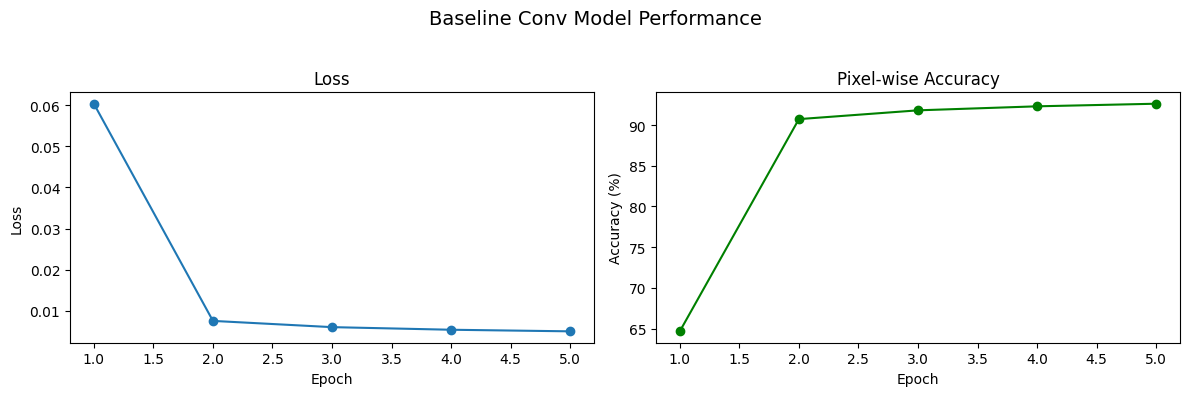

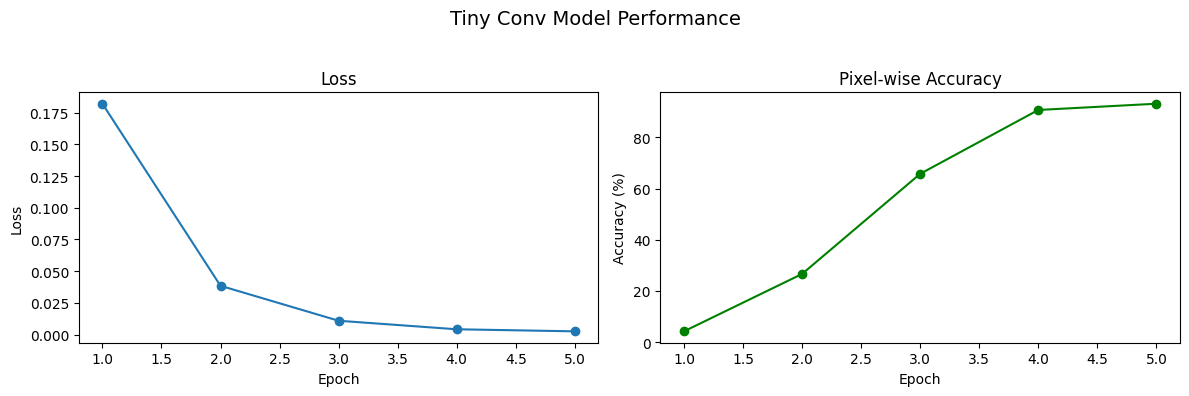

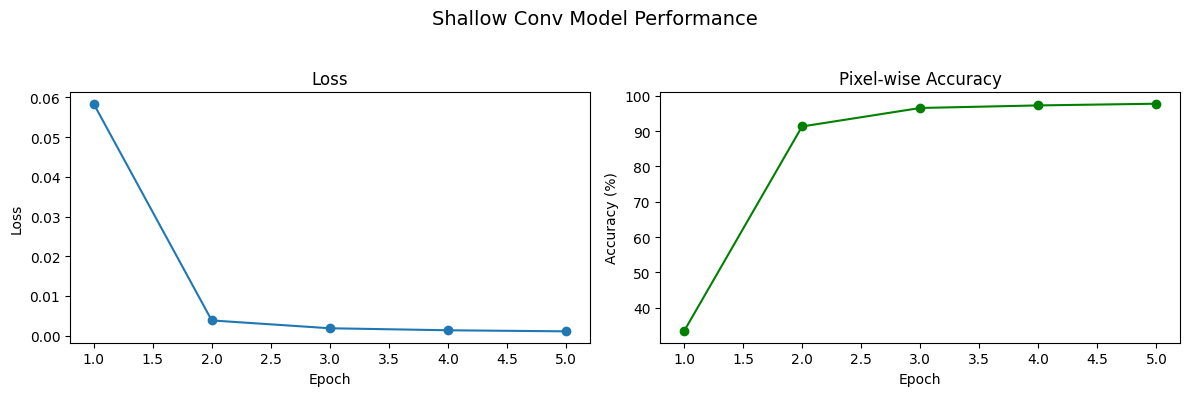

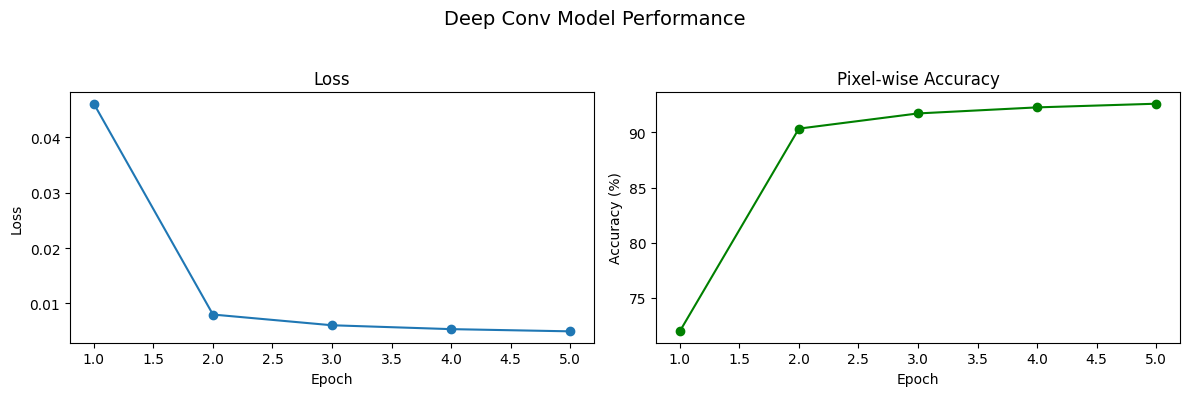

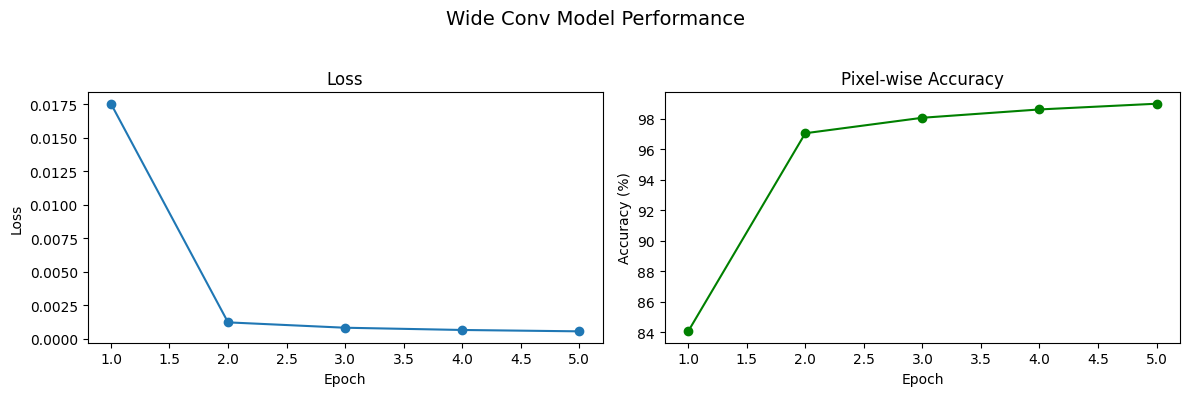

In [ ]:
for arch_name, history in histories.items():
    history.plot(title=f"{arch_name} Conv Model Performance")

**Model Analysis (5 epochs):**

- **Baseline Conv Model**: Achieves high pixel-wise accuracy (~94%) very quickly, with loss dropping sharply after the first epoch. This model performs robustly and converges fast.

- **Tiny Conv Model:** Starts with high loss and low accuracy but improves significantly over epochs, reaching ~88% accuracy, though it still lags behind larger models.

- **Shallow Conv Model:** Shows rapid improvement in both loss and accuracy, reaching ~96% accuracy, suggesting strong performance with minimal depth.

- **Deep Conv Model:** Achieves slightly lower final accuracy (~93%) compared to shallower or wider models, indicating potential overfitting or inefficiency in learning.

- **Wide Conv Model:** Consistently achieves the highest pixel-wise accuracy (~98%) and lowest loss, indicating excellent capacity for learning complex representations.

**Conclusion:** While all models improve over time, the Wide Conv Model demonstrates the best overall performance, suggesting that increasing width is more effective than depth for this task.

#### Identify best and worst conv architectures

In [ ]:
sorted_histories = dict(sorted(histories.items(), key=key))
for i, (arch_name, history) in enumerate(sorted_histories.items(), start=1):
    print(f"{i}. {arch_name:<8} : final loss = {history.loss[-1]:.4f}")

1. Wide     : final loss = 0.0006
2. Shallow  : final loss = 0.0011
3. Tiny     : final loss = 0.0026
4. Deep     : final loss = 0.0049
5. Baseline : final loss = 0.0050


In [ ]:
best_conv_ae_model_name = min(histories.items(), key=key)[0]
worst_conv_ae_model_name = max(histories.items(), key=key)[0]

print(f"Best ConvAE model:  {best_conv_ae_model_name}")
print(f"Worst ConvAE model: {worst_conv_ae_model_name}")

Best ConvAE model:  Wide
Worst ConvAE model: Baseline


#### Fully retrain best and wrost models

In [ ]:
n_epochs = 8  # Appears to be sufficient

best_conv_ae_model = ConfigurableConvAutoencoder(conv_architectures[best_conv_ae_model_name]).to(DEVICE)
worst_conv_ae_model = ConfigurableConvAutoencoder(conv_architectures[worst_conv_ae_model_name]).to(DEVICE)

print(f"Retraining the best conv model ({best_conv_ae_model_name})...")
best_conv_history = best_conv_ae_model.fit(train_loader, optim.Adam(best_conv_ae_model.parameters(), lr=learning_rate), criterion, n_epochs)

print("\n")

print(f"Retraining the worst conv model ({worst_conv_ae_model_name})...")
worst_conv_history = worst_conv_ae_model.fit(train_loader, optim.Adam(worst_conv_ae_model.parameters(), lr=learning_rate), criterion, n_epochs)

Retraining the best conv model (Wide)...


Training ConfigurableConvAutoencoder:   0%|          | 0/8 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/8, Loss: 0.0223, Pixel-wise Accuracy: 83.70%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/8, Loss: 0.0010, Pixel-wise Accuracy: 97.52%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/8, Loss: 0.0007, Pixel-wise Accuracy: 98.37%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/8, Loss: 0.0006, Pixel-wise Accuracy: 98.84%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/8, Loss: 0.0005, Pixel-wise Accuracy: 99.15%


Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/8, Loss: 0.0005, Pixel-wise Accuracy: 99.35%


Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/8, Loss: 0.0004, Pixel-wise Accuracy: 99.49%


Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/8, Loss: 0.0004, Pixel-wise Accuracy: 99.58%


Retraining the worst conv model (Baseline)...


Training ConfigurableConvAutoencoder:   0%|          | 0/8 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/8, Loss: 0.0454, Pixel-wise Accuracy: 66.23%


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/8, Loss: 0.0049, Pixel-wise Accuracy: 92.73%


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/8, Loss: 0.0037, Pixel-wise Accuracy: 93.78%


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/8, Loss: 0.0033, Pixel-wise Accuracy: 94.21%


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/8, Loss: 0.0030, Pixel-wise Accuracy: 94.48%


Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/8, Loss: 0.0028, Pixel-wise Accuracy: 94.67%


Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/8, Loss: 0.0027, Pixel-wise Accuracy: 94.81%


Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/8, Loss: 0.0026, Pixel-wise Accuracy: 94.91%


#### Visual reconstructions

Reconstructions with the BEST model (Wide)


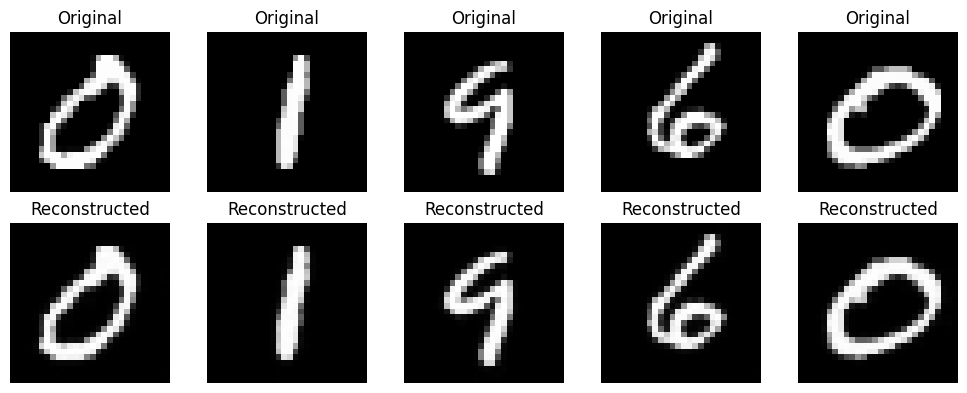



Reconstructions with the WORST model (Baseline)


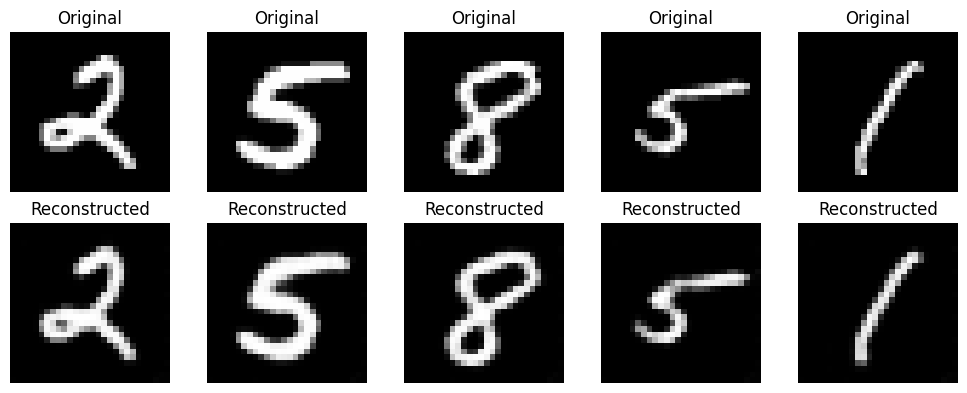

In [ ]:
print(f"Reconstructions with the BEST model ({best_conv_ae_model_name})")
visualize_reconstructions(best_conv_ae_model, train_loader)

print("\n")

print(f"Reconstructions with the WORST model ({worst_conv_ae_model_name})")
visualize_reconstructions(worst_conv_ae_model, train_loader)

Both the best and worst models reconstruct the images very well.

### Explain the differences between fully connected and convolutional autoencoders

The fully connected (linear) autoencoder treats the input image as a flat vector, losing spatial structure information. It often requires more parameters and may not generalize well to images with spatial patterns.

The convolutional autoencoder preserves the spatial structure by using convolutional layers, capturing local features like edges and textures more effectively. This typically leads to better reconstruction quality and more efficient training.

In general, for image data, convolutional architectures are preferred because they exploit the inherent spatial correlations and are more parameter-efficient.

Therefore, I would prefer the convolutional autoencoder for image reconstruction tasks.